<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_WordPiece_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tokenització de WordPiece**

---

La tokenització WordPiece és un mètode de segmentació de text en “subparaules” (subwords) que s’usa àmpliament en models de transformadors com BERT.

**Definició**:

WordPiece comença amb un vocabulari de caràcters (per exemple lletres, dígits, símbols) i, mitjançant un procediment d’aprenentatge basat en la freqüència de seqüències, construeix un vocabulari de fragments de paraules. A l’hora de processar text nou, cada paraula es descompon en la sèrie de fragments més llarga possible que apareguin al vocabulari.

**Per què serveix?**

1. Reducció de la mida del vocabulari: en lloc de tenir un vocabulari gegantí amb totes les paraules possibles, només es guarden fragments comuns (p. ex., “inter”, “-essant”, “-isme”).

1. Cobertura oberta (open vocabulary): permet manejar paraules mai vistes (“OOV”) segmentant-les en subparaules conegudes.

1. Equilibri entre caràcters i paraules completes: evita que el model es vegi aclaparat per fragments massa petits (com en la tokenització per caràcters) o per vocabularis massa grans (com en la tokenització estrictament per paraules).

1. Millora de l’aprenentatge de representacions: com que els subparaules capturen patrons morfològics (prefixos, sufixos, arrels), els embeddings aprenen millor relacions semàntiques i sintàctiques.

WordPiece parteix d'un petit vocabulari que inclou les fitxes especials utilitzades pel model i l'alfabet inicial. Com que identifica subparaules afegint un prefix (com ##per a BERT), cada paraula es divideix inicialment afegint aquest prefix a tots els caràcters de la paraula.

Així, l'alfabet inicial conté tots els caràcters presents al començament d'una paraula i els caràcters presents dins d'una paraula precedits del prefix WordPiece.


WordPiece aprèn les regles de combinació. La diferència principal és la manera com es selecciona la parella que s'ha de combinar. En lloc de seleccionar la parella més freqüent, WordPiece calcula una puntuació per a cada parell, utilitzant la fórmula següent:

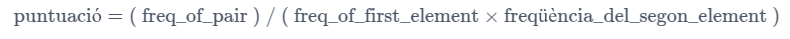

**Algorisme de tokenització**

---
La tokenització difereix a WordPiece i BPE, ja que WordPiece només guarda el vocabulari final, no les regles de fusió apreses. A partir de la paraula a tokenitzar, WordPiece troba la subparaula més llarga que hi ha al vocabulari i, a continuació, la divideix.


**Implementació de WordPiece**

---



In [1]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
#Calcular les freqüències de cada parula del corpus

from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

L'alfabet és l'únic conjunt format per:

1. Totes les primeres lletres de les paraules.
1. I totes les altres lletres que apareixen en paraules amb el prefix **##**.

In [ ]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

In [5]:
#També afegim les fitxes especials utilitzades pel model.

vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

In [6]:
# Dividir cada paraula, amb totes les lletres que no són les primeres prefixades per ##:

splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

In [7]:
# Ara, l'entrenament, escrivim una funció que calculi la puntuació de cada parella. Haurem d'utilitzar això a cada pas de la formació

def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [ ]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

In [ ]:
# La parella amb millor puntuació

best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

In [10]:
# Afegim al vocabulari la parella 'ab'

vocab.append("ab")

In [11]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [ ]:
splits = merge_pair("a", "##b", splits)
splits["about"]

In [13]:
# Aprenent les fusions i afegint-les al vocabulari

vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [ ]:
print(vocab)

**Tokenitzar un text nou**

---

Per tokenitzar un text nou, el pre-tokenitzem, el dividim i després apliquem l'algoritme de tokenització a cada paraula.

In [15]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [ ]:
print(encode_word("Hugging"))
print(encode_word("HOgging"))

In [17]:
# Per un text

def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [ ]:
tokenize("This is the Hugging Face course!")